In [538]:
import numpy as np
import os as os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
import scipy
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")


#setting up dataset paths
base_path = r"C:\Users\Mehrab\test\Kaggle_project_data\drug_MoAs"
save_path = r"C:\Users\Mehrab\test\Kaggle_projects\drug_MoAs"
train_features_path = os.path.join(base_path, 'train_features.csv')
train_targets_path = os.path.join(base_path, 'train_targets_scored.csv')
train_targets_nonscored_path = os.path.join(base_path, 'train_targets_nonscored.csv')

#reading in datasets
features = pd.read_csv(train_features_path)
targets = pd.read_csv(train_targets_path)

features_orig = features
targets_orig = targets

# filter warnings
import warnings
warnings.filterwarnings('ignore')

r_seed = 8

<h1>
Task definition:
</h1> <br />
The goal is to use the features to predict the mechanism of action of a series of different drugs, encoded in target.
<br /><br /><br />
<h2>Exploring Features and Targets</h2><br />
Step1: Data loading sanity checks and basic datatype identification. 

In [539]:
print(f"Shape of features df: {features.shape}")
print(f"Number of missing values: {features.isna().sum().sum()}")
features.head()

Shape of features df: (23814, 876)
Number of missing values: 0


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


1. features table successfully read in, with 876 feature columns and 23814 treatment rows and has no missing values
2. column sig_id has identifiers for the drugs used for treatment. Need to check if row order is maintained in features and targets

In [540]:
print(f"cp_type has unique values values {pd.unique(features['cp_type'])} and encodes drug treatment v/s vehicle control (nominal).")
print(f"cp_time has unique values values {pd.unique(features['cp_time'])} and encodes duration of treatment (ordinal).")
print(f"cp_dose has unique values values {pd.unique(features['cp_dose'])} and encodes treatment dosage (ordinal).")
print('The rest of the feature columns are numeric values encoding anonymised gene expression scores (g-xx) or cell fate scores (c-xx).')


cp_type has unique values values ['trt_cp' 'ctl_vehicle'] and encodes drug treatment v/s vehicle control (nominal).
cp_time has unique values values [24 72 48] and encodes duration of treatment (ordinal).
cp_dose has unique values values ['D1' 'D2'] and encodes treatment dosage (ordinal).
The rest of the feature columns are numeric values encoding anonymised gene expression scores (g-xx) or cell fate scores (c-xx).


In [541]:
print(targets.shape)
targets.head()

(23814, 207)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1. targets table successfully read in, with 207 possible targets and 23814 treatment rows.

In [542]:
print('Verifying that features and targets have the same ordering of rows:')
features['sig_id'].equals(targets['sig_id'])

Verifying that features and targets have the same ordering of rows:


True

In [543]:
print('Dropped sig_id from features and targets since it is redundant.')
features = features_orig.drop(['sig_id'], axis = 1)
targets = targets_orig.drop(['sig_id'], axis = 1)

Dropped sig_id from features and targets since it is redundant.


In [544]:
print(f"Maximum value in targets in any row/column: {np.max(targets.max())}")
print(f"Minimum value in targets in any row/column: {np.min(targets.min())}")
print(f"Maximum  number of unique values of any target column: {np.max(targets.nunique())}")

Maximum value in targets in any row/column: 1
Minimum value in targets in any row/column: 0
Maximum  number of unique values of any target column: 2


Each column is a possible mechanism of action (MoA) for a drug treatment, and each treatment or row can either have a hit (1) or not (0) for a given MoA.

Maximum number of MoA hits for any row: 7


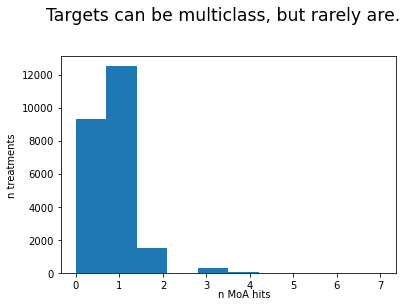

In [545]:
sum_vals = targets.sum(axis = 1)
plot_hist(sum_vals, 'n MoA hits', 'n treatments', 'Targets can be multiclass, but rarely are.')  #histogram of n MoA hits
print(f"Maximum number of MoA hits for any row: {np.max(sum_vals)}")

#Note: Be sure to run worker-functions cell at the bottom of this notebook.

Now that we know what the features and targets consist of, they should be split into training and validation sets before further exploratory analyses to prevent information leakage.

In [546]:
X_train, X_valid, y_train, y_valid = train_test_split(features_orig, targets_orig, test_size = 0.2, shuffle = True, random_state = r_seed)

<br />
<h2>Detailed exploratory analyses of training-set features and targets</h2>

In [547]:
cxx_cols =  [i for i in X_train.columns if i.startswith('c-')]  #list of c-xx (cell viability) feature cols
print(f"n c-xx columns: {len(cxx_cols)}")
gxx_cols =  [i for i in X_train.columns if i.startswith('g-')]  #list of c-xx (cell viability) feature cols
print(f"n g-xx columns: {len(gxx_cols)}")
trt_rows = np.where(feature_df['cp_type'].str.contains('trt_cp'))[0]
ctl_rows = np.where(feature_df['cp_type'].str.contains('ctl_vehicle'))[0]

n c-xx columns: 100
n g-xx columns: 772


(n c-xx cols + n g-xx cols) + cp_type + cp_time + cp_dose = 875. This accounts for all feature columns (sig_id was dropped).
<br /><br /><br /><br />
<h3>First, exploring the values in c-xx and g-xx columns<h3>

<h3>Looking for any trends in Cell-viability feature values depending on treatment dosage</h3>

In [548]:
print(f"Treatments can have one of two dosages: {X_train['cp_dose'].unique()}")
D1_rows = X_train[((X_train['cp_dose'].isin(['D1']) ) & (X_train['cp_type'].isin(['trt_cp'])))]
print(f"Number of D1 dosage rows: {len(D1_rows)}")
D2_rows = X_train[((X_train['cp_dose'].isin(['D2']) ) & (X_train['cp_type'].isin(['trt_cp'])))]
print(f"Number of D2 dosage rows: {len(D2_rows)}")

Treatments can have one of two dosages: ['D2' 'D1']
Number of D1 dosage rows: 8960
Number of D2 dosage rows: 8601


In [549]:
D1_sigids = D1_rows['sig_id']
D2_sigids = D2_rows['sig_id']
print(f"The number of shared sig_ids for D1 and D2 dosages: {len(D1_sigids.loc[D1_sigids.isin(D2_sigids)])}")

The number of shared sig_ids for D1 and D2 dosages: 0


Since the drug delivered in each treatment row is anonymised, we cannot compare across dosages for a given drug - comparing as pooled populations.

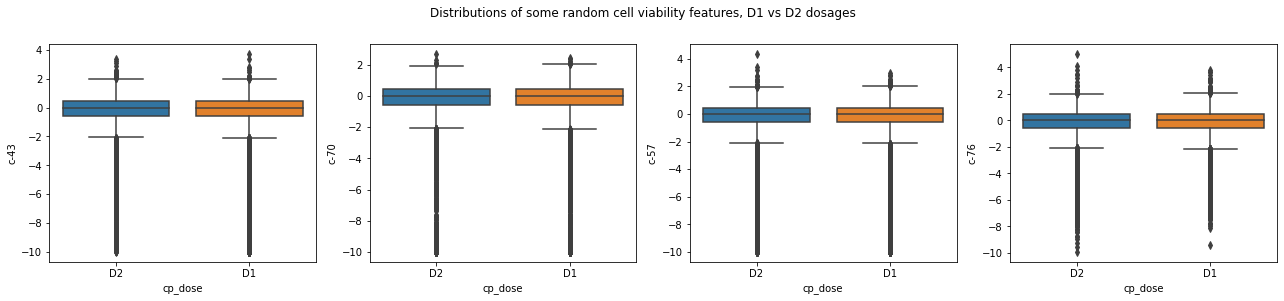

In [550]:
plt.figure(figsize = (22, 4))
plt.suptitle('Distributions of some random cell viability features, D1 vs D2 dosages', y = 1.01)
for e, col in enumerate(np.random.choice(cxx_cols, size = 4)):
    plt.subplot(1,4, e+1)
    sns.boxplot(data = X_train, x = 'cp_dose', y = col)

There isn't much difference between cell viability feature values across D1 and D2 dosages. This is not so surprising since different drug treatments have been pooled and the feature values have been pre-scaled. 

<h3>Looking for any trends in Gene-expression feature values depending on treatment dosage</h3>

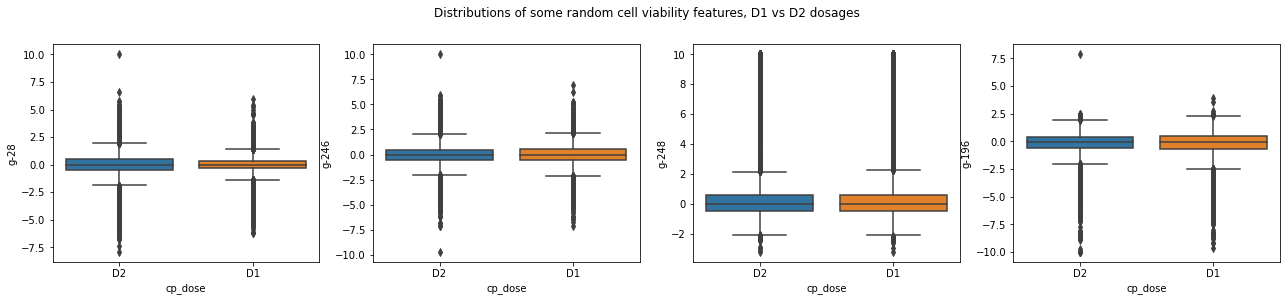

In [551]:
plt.figure(figsize = (22, 4))
plt.suptitle('Distributions of some random cell viability features, D1 vs D2 dosages', y = 1.01)
for e, col in enumerate(np.random.choice(gxx_cols, size = 4)):
    plt.subplot(1,4, e+1)
    sns.boxplot(data = X_train, x = 'cp_dose', y = col)

There isn't much difference between gene expression feature values across D1 and D2 dosages either. Again, this is not so surprising since different drug treatments have been pooled and the feature values have been pre-scaled. 

<h3>Looking for any trends in Cell-viability feature values depending on treatment duration</h3>

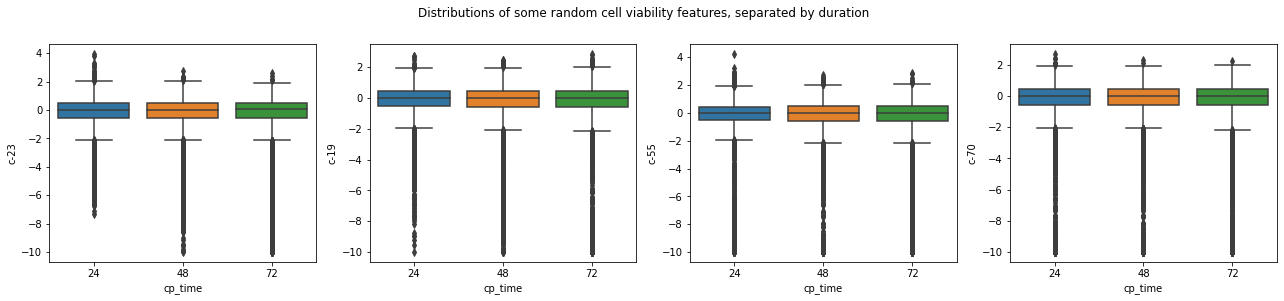

In [552]:
plt.figure(figsize = (22, 4))
plt.suptitle('Distributions of some random cell viability features, separated by duration', y = 1.01)
for e, col in enumerate(np.random.choice(cxx_cols, size = 4)):
    plt.subplot(1,4, e+1)
    sns.boxplot(data = X_train, x = 'cp_time', y = col)

<h3>Looking for any trends in Gene-expression feature values depending on treatment duration</h3>

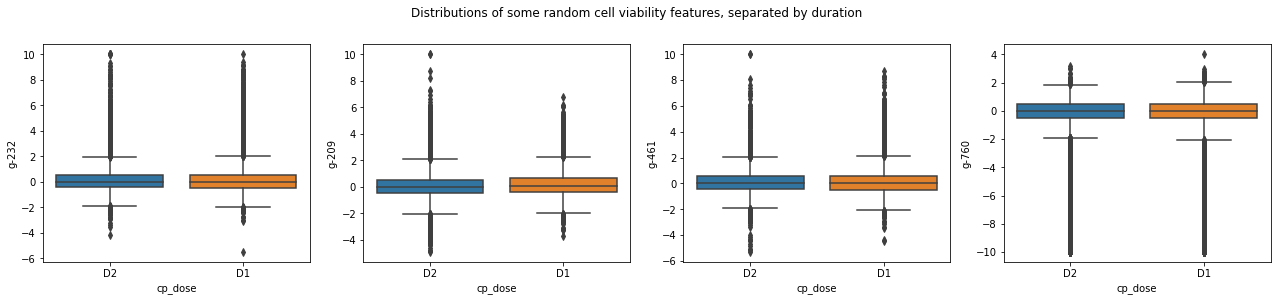

In [553]:
plt.figure(figsize = (22, 4))
plt.suptitle('Distributions of some random cell viability features, separated by duration', y = 1.01)
for e, col in enumerate(np.random.choice(gxx_cols, size = 4)):
    plt.subplot(1,4, e+1)
    sns.boxplot(data = X_train, x = 'cp_dose', y = col)

There isn't much difference between gene expression feature values across treatment durations either. Again, this is not so surprising since different drug treatments have been pooled and the feature values have been pre-scaled. 

<br/><br/><br/><br/>
<h2>Inspecting distributions of cell viability features and rescaling/transforming as needed </h2>

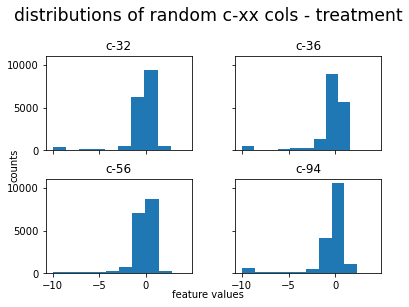

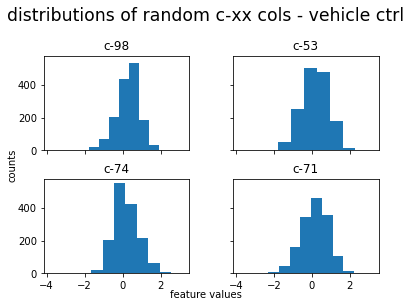

In [554]:
#summarising ctrl, treatment data separately for manual/visual inspection

#historgrms of randomly chosen columns
#with drug treatment rows only
plot_col_hists(X_train, cxx_cols, 'trt_cp', 4, 'distributions of random c-xx cols - treatment', r_seed)

#vehicle control rows only
plot_col_hists(X_train, cxx_cols, 'ctl_vehicle', 4, 'distributions of random c-xx cols - vehicle ctrl', r_seed)

The values in c-xx columns seem to be 0-centered, negatively skewed distributions. But need to visualize all the distributions to be sure.

Mean cxx column skewness for treatment rows = -3.17999227869752
Mean cxx column kurtosis for treatment rows = 11.154506727240607
Mean cxx column skewness for vehicle control rows = -1.1167732787280624
Mean cxx column kurtosis for vehicle control rows = 5.868916447544585


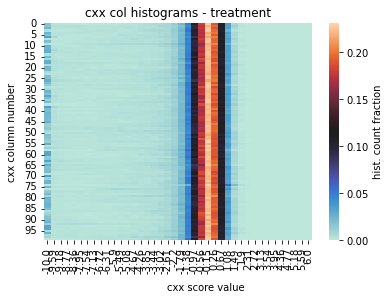

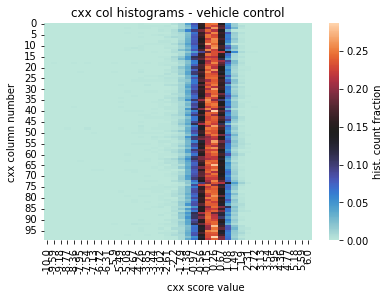

In [555]:
#treatment
clrmap = sns.color_palette("icefire", as_cmap=True)
hist_range, trt_hists, ctl_hists, trt_array, ctl_array = get_hist_array(X_train, cxx_cols, 40)
fig, (ax1) = plt.subplots(nrows=1)
sns.heatmap(trt_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap)
fig.text(0.5, -0.05, 'cxx score value', ha='center')
fig.text(0.040, 0.5, 'cxx column number', va='center', rotation='vertical')
ax1.set(title = "cxx col histograms - treatment")
print(f"Mean cxx column skewness for treatment rows = {np.mean(scipy.stats.skew(trt_array, axis = 1))}")
print(f"Mean cxx column kurtosis for treatment rows = {np.mean(scipy.stats.kurtosis(trt_array, axis = 1))}")

#vehicle control
fig2, (ax2) = plt.subplots(nrows=1)
sns.heatmap(ctl_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap)
fig2.text(0.5, -0.05, 'cxx score value', ha='center')
fig2.text(0.040, 0.5, 'cxx column number', va='center', rotation='vertical')
ax2.set(title = "cxx col histograms - vehicle control")
print(f"Mean cxx column skewness for vehicle control rows = {np.mean(scipy.stats.skew(ctl_array, axis = 1))}")
print(f"Mean cxx column kurtosis for vehicle control rows = {np.mean(scipy.stats.kurtosis(ctl_array, axis = 1))}")

The heatmaps above depict histograms of the values taken in all the cxx columns. Each row is a different column. The scores range from -10 to 6.0, with most values distributed around 0. For treatment rows, there are scattered, rare values skewing toward the negative side and end, visible as dark blue shading to the left of the peak. These extreme values are much rarer or absent for the vehicle control rows. Mean kurtosis is also high, reflected by the large number of outlier-values, especially in the treatment rows. These will need to be transformed to be more gaussian-like to better use the model's dynamic range. 

Mean transformed cxx column skewness for treatment rows = 0.017512500123672562
Mean cxx column kurtosis for treatment rows = 2.9176379489824575
Mean transformed cxx column skewness for vehicle control rows = 0.8572368708905939
Mean cxx column kurtosis for vehicle control rows = 1.6987041699732006


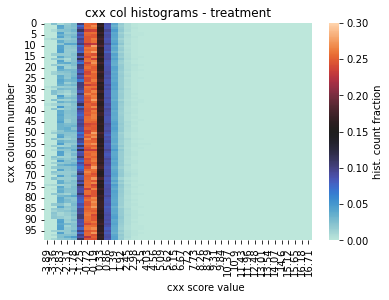

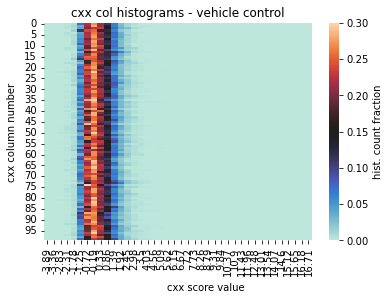

In [557]:
#fitting power transformer to cxx columns from training features
pt_cxx_cols = PowerTransformer()
pt_cxx_cols.fit(X_train[cxx_cols])
X_train_orig = X_train
X_train[cxx_cols] = pt_cxx_cols.transform(X_train[cxx_cols])


#treatment
clrmap = sns.color_palette("icefire", as_cmap=True)
hist_range, trt_hists, ctl_hists, trt_array, ctl_array = get_hist_array(X_train, cxx_cols, 40)
fig, (ax1) = plt.subplots(nrows=1)
sns.heatmap(trt_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig.text(0.5, -0.05, 'cxx score value', ha='center')
fig.text(0.040, 0.5, 'cxx column number', va='center', rotation='vertical')
ax1.set(title = "cxx col histograms - treatment")
print(f"Mean transformed cxx column skewness for treatment rows = {np.mean(scipy.stats.skew(trt_array, axis = 1))}")
print(f"Mean cxx column kurtosis for treatment rows = {np.mean(scipy.stats.kurtosis(trt_array, axis = 1))}")

#vehicle control
fig2, (ax2) = plt.subplots(nrows=1)
sns.heatmap(ctl_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig2.text(0.5, -0.05, 'cxx score value', ha='center')
fig2.text(0.040, 0.5, 'cxx column number', va='center', rotation='vertical')
ax2.set(title = "cxx col histograms - vehicle control")
print(f"Mean transformed cxx column skewness for vehicle control rows = {np.mean(scipy.stats.skew(ctl_array, axis = 1))}")
print(f"Mean cxx column kurtosis for vehicle control rows = {np.mean(scipy.stats.kurtosis(ctl_array, axis = 1))}")

<b> The distributions of c_xx column values for treatment rows are now much more symmetric around 0, with the negative extreme values. The mean distribution skewness has also dropped ten-fold from ~ -3 to 0.3 for the treatment rows ie. closer to 0, the expected value for a normal distribution. Mean kurtosis values are also close to 3.0, the expected value for a normal distribution. </b>
<br/><br/><br/>

<h3>Next we examine how correlated the cell-viability features are with each other or how much distinct information they carry.</h3>

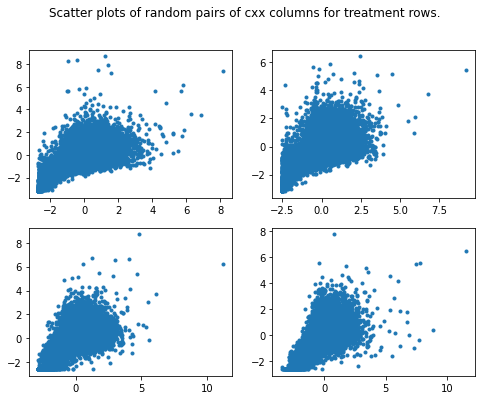

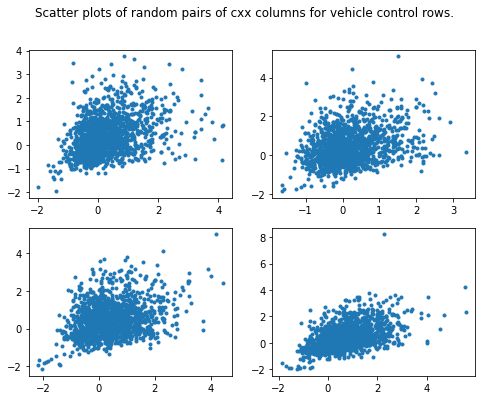

In [558]:
plt.figure(figsize = (8, 6))
plt.suptitle('Scatter plots of random pairs of cxx columns for treatment rows.')
r_pairs = np.random.randint(0, (len(cxx_cols) + 1), (4, 2))
for e, rand_n in enumerate(r_pairs):
    plt.subplot(2, 2, e+1)
    col1_vals = np.asarray(X_train.iloc[trt_rows, [X_train.columns.get_loc(cxx_cols[rand_n[0]])] ])
    col2_vals = np.asarray(X_train.iloc[trt_rows, [X_train.columns.get_loc(cxx_cols[rand_n[1]])] ])
    plt.plot(col1_vals, col2_vals, '.')
        
    
plt.figure(figsize = (8, 6))
plt.suptitle('Scatter plots of random pairs of cxx columns for vehicle control rows.')
r_pairs = np.random.randint(0, (len(cxx_cols) + 1), (4, 2))
for e, rand_n in enumerate(r_pairs):
    plt.subplot(2, 2, e+1)
    col1_vals = np.asarray(X_train.iloc[ctl_rows, [X_train.columns.get_loc(cxx_cols[rand_n[0]])] ])
    col2_vals = np.asarray(X_train.iloc[ctl_rows, [X_train.columns.get_loc(cxx_cols[rand_n[1]])] ])
    plt.plot(col1_vals, col2_vals, '.')    

Cell-viability feature values are correlated with each other. 

Looking at correlations across all cell-viability feature column-pairs. 

<AxesSubplot:>

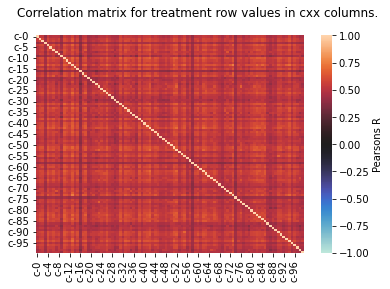

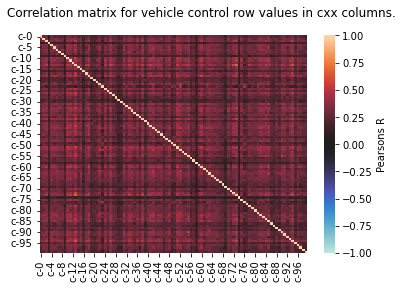

In [464]:
#treatment rows
sub_df = X_train[cxx_cols]
corr_mat = sub_df.iloc[trt_rows, :].corr()
plt.figure()
plt.suptitle('Correlation matrix for treatment row values in cxx columns.')
sns.heatmap(corr_mat, cbar_kws={'label': 'Pearson''s R'}, cmap = clrmap, vmin = -1, vmax = 1)

#vehicle control rows
corr_mat = sub_df.iloc[ctl_rows, :].corr()
plt.figure()
plt.suptitle('Correlation matrix for vehicle control row values in cxx columns.')
sns.heatmap(corr_mat, cbar_kws={'label': 'Pearson''s R'}, cmap = clrmap, vmin = -1, vmax = 1)



<b>When a drug treatment is given, cell-viability features are quite correlated with each other. They might encode redundant information. It would make model-training  faster if these rows were expressed as principal components to reduce the number of features. </b>
<br/><br/><br/><br/>



<h3>Computing a Principal Component transformation of cell-viability features and measuring variability captured.</h3>

Text(0, 0.5, 'cumul. sum variance captured')

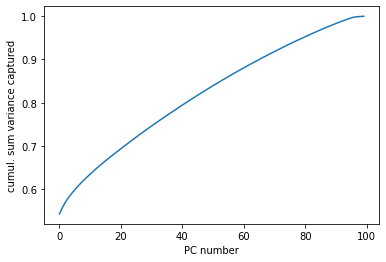

In [535]:
n_PCs = 100    #determined manually after trying a few numbers 
pca_obj = PCA(n_components = n_PCs)
pca_obj.fit(X_train[cxx_cols])    #This fitted object contains the feature weights needed to project into PC space

vars = pca_obj.explained_variance_ratio_
fig, (ax1) = plt.subplots()
vars = np.cumsum(vars)
plt.plot(vars)

ax1.set_xlabel('PC number')
ax1.set_ylabel('cumul. sum variance captured')

<b>60 columns capture ~90% of the variance in the cell-viability features. It might be worth trying to replace cell-viability feature columns with their PC transformations during model training.</b>

<br/><br/><br/><br/>
<h2>Inspecting distributions of gene-expression features and rescaling/transforming as needed </h2>

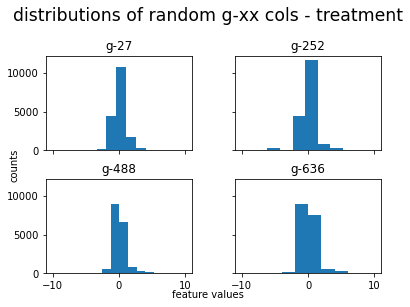

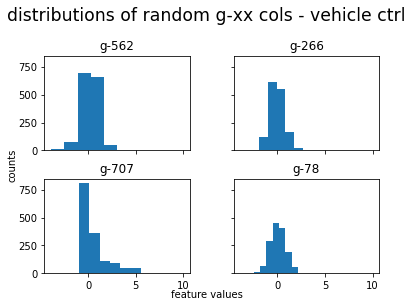

In [520]:
#summarising ctrl, treatment data separately for manual/visual inspection

#historgrms of randomly chosen columns
#with drug treatment rows only
plot_col_hists(X_train, gxx_cols, 'trt_cp', 4, 'distributions of random g-xx cols - treatment', r_seed)

#vehicle control rows only
plot_col_hists(X_train, gxx_cols, 'ctl_vehicle', 4, 'distributions of random g-xx cols - vehicle ctrl', r_seed)

The values in c-xx columns seem to be 0-centered distributions without much skew. But need to visualize all the distributions to be sure.

Mean gxx column skewness for treatment rows = 0.10056277703281444
Mean gxx column kurtosis for treatment rows = 8.71531066963983
Mean gxx column skewness for vehicle control rows = 0.03335040257958102
Mean gxx column kurtosis for vehicle control rows = 4.812127763507568


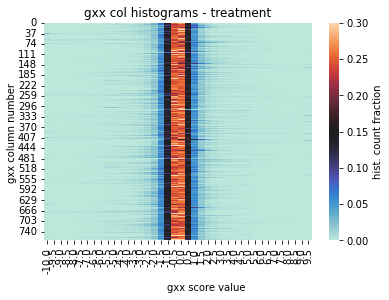

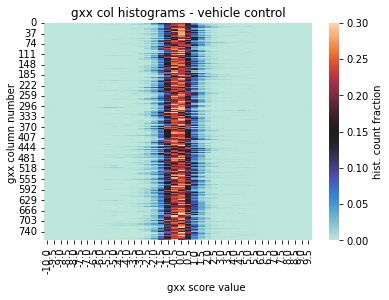

In [559]:
#treatment
clrmap = sns.color_palette("icefire", as_cmap=True)
hist_range, trt_hists, ctl_hists, trt_array, ctl_array = get_hist_array(X_train, gxx_cols, 40)
fig, (ax1) = plt.subplots(nrows=1)
sns.heatmap(trt_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig.text(0.5, -0.05, 'gxx score value', ha='center')
fig.text(0.040, 0.5, 'gxx column number', va='center', rotation='vertical')
ax1.set(title = "gxx col histograms - treatment")
print(f"Mean gxx column skewness for treatment rows = {np.mean(scipy.stats.skew(trt_array, axis = 1))}")
print(f"Mean gxx column kurtosis for treatment rows = {np.mean(scipy.stats.kurtosis(trt_array, axis = 1))}")

#vehicle control
fig2, (ax2) = plt.subplots(nrows=1)
sns.heatmap(ctl_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig2.text(0.5, -0.05, 'gxx score value', ha='center')
fig2.text(0.040, 0.5, 'gxx column number', va='center', rotation='vertical')
ax2.set(title = "gxx col histograms - vehicle control")
print(f"Mean gxx column skewness for vehicle control rows = {np.mean(scipy.stats.skew(ctl_array, axis = 1))}")
print(f"Mean gxx column kurtosis for vehicle control rows = {np.mean(scipy.stats.kurtosis(ctl_array, axis = 1))}")

The heatmaps above depict histograms of the values taken in all the gene expression feature columns. Each row is a different column. The scores range from -10 to 10, with most values distributed around 0. For treatment rows and control rows, there are scattered, rare negative and positive values. But the kurtosis values are a little high, probably reflecting symmetrically distributed outliers. 

In [561]:
#fitting power transformer to cxx columns from training features
qt_gxx_cols = QuantileTransformer(output_distribution= 'normal')
qt_gxx_cols.fit(X_train[gxx_cols])
X_train_orig = X_train
X_train[gxx_cols] = pt_gxx_cols.transform(X_train[gxx_cols])


#treatment
clrmap = sns.color_palette("icefire", as_cmap=True)
hist_range, trt_hists, ctl_hists, trt_array, ctl_array = get_hist_array(X_train, gxx_cols, 40)
fig, (ax1) = plt.subplots(nrows=1)
sns.heatmap(trt_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig.text(0.5, -0.05, 'gxx score value', ha='center')
fig.text(0.040, 0.5, 'gxx column number', va='center', rotation='vertical')
ax1.set(title = "gxx col histograms - treatment")
print(f"Mean transformed gxx column skewness for treatment rows = {np.mean(scipy.stats.skew(trt_array, axis = 1))}")
print(f"Mean gxx column kurtosis for treatment rows = {np.mean(scipy.stats.kurtosis(trt_array, axis = 1))}")

#vehicle control
fig2, (ax2) = plt.subplots(nrows=1)
sns.heatmap(ctl_hists, xticklabels = list(map(str, hist_range[0:-1])), cbar_kws={'label': 'hist. count fraction'}, cmap = clrmap, vmin = 0, vmax = 0.3)
fig2.text(0.5, -0.05, 'gxx score value', ha='center')
fig2.text(0.040, 0.5, 'gxx column number', va='center', rotation='vertical')
ax2.set(title = "gxx col histograms - vehicle control")
print(f"Mean transformed gxx column skewness for vehicle control rows = {np.mean(scipy.stats.skew(ctl_array, axis = 1))}")
print(f"Mean gxx column kurtosis for vehicle control rows = {np.mean(scipy.stats.kurtosis(ctl_array, axis = 1))}")

NameError: name 'QuantileTransformer' is not defined

<b> The distributions of c_xx column values for treatment rows are now much more symmetric around 0, with the negative extreme values. The mean distribution skewness has also dropped ten-fold from ~ -3 to 0.3 for the treatment rows ie. closer to 0, the expected value for a normal distribution. Mean kurtosis values are also close to 3.0, the expected value for a normal distribution. </b>
<br/><br/><br/>

<h3>Next we examine how correlated the cell-viability features are with each other or how much distinct information they carry.</h3>

<h3> Next we examine how correlated the gene-expression features are with each other or how much distinct information they carry.</h3>

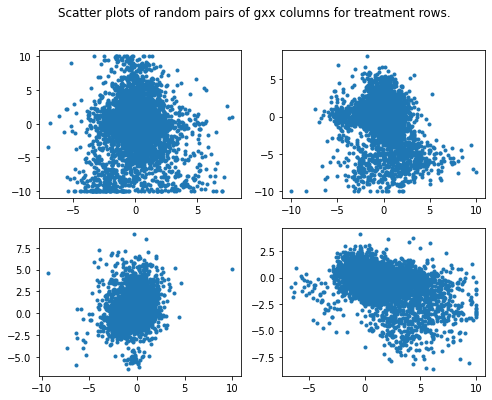

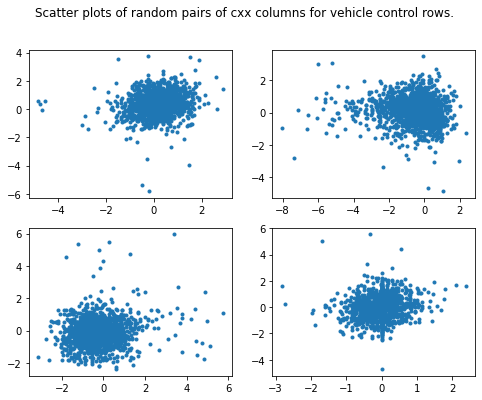

In [522]:
plt.figure(figsize = (8, 6))
plt.suptitle('Scatter plots of random pairs of gxx columns for treatment rows.')
r_pairs = np.random.randint(0, (len(gxx_cols) + 1), (4, 2))
for e, rand_n in enumerate(r_pairs):
    plt.subplot(2, 2, e+1)
    col1_vals = np.asarray(X_train.iloc[trt_rows, [X_train.columns.get_loc(gxx_cols[rand_n[0]])] ])
    col2_vals = np.asarray(X_train.iloc[trt_rows, [X_train.columns.get_loc(gxx_cols[rand_n[1]])] ])
    plt.plot(col1_vals, col2_vals, '.')
        
    
plt.figure(figsize = (8, 6))
plt.suptitle('Scatter plots of random pairs of cxx columns for vehicle control rows.')
r_pairs = np.random.randint(0, (len(gxx_cols) + 1), (4, 2))
for e, rand_n in enumerate(r_pairs):
    plt.subplot(2, 2, e+1)
    col1_vals = np.asarray(X_train.iloc[ctl_rows, [X_train.columns.get_loc(gxx_cols[rand_n[0]])] ])
    col2_vals = np.asarray(X_train.iloc[ctl_rows, [X_train.columns.get_loc(gxx_cols[rand_n[1]])] ])
    plt.plot(col1_vals, col2_vals, '.')    

Gene-expression feature values seem less correlated with each other than cell-viability features. 

Looking at correlations across all gene-expression feature column-pairs. 

<AxesSubplot:>

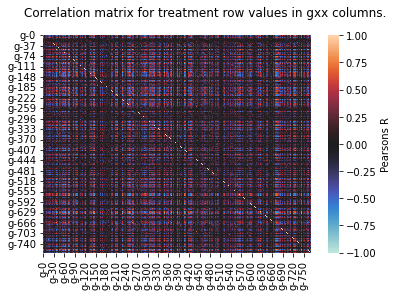

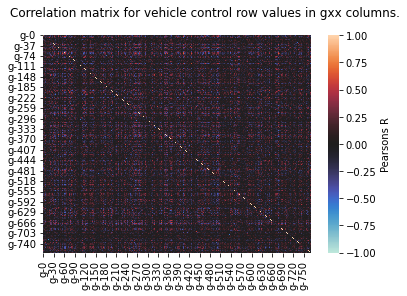

In [523]:
#treatment rows
sub_df = X_train[gxx_cols]
corr_mat = sub_df.iloc[trt_rows, :].corr()
plt.figure()
plt.suptitle('Correlation matrix for treatment row values in gxx columns.')
sns.heatmap(corr_mat, cbar_kws={'label': 'Pearson''s R'}, cmap = clrmap, vmin = -1, vmax = 1)

#vehicle control rows
corr_mat = sub_df.iloc[ctl_rows, :].corr()
plt.figure()
plt.suptitle('Correlation matrix for vehicle control row values in gxx columns.')
sns.heatmap(corr_mat, cbar_kws={'label': 'Pearson''s R'}, cmap = clrmap, vmin = -1, vmax = 1)



<b>When a drug treatment is given, gene-expression features are poorly correlated with each other and are likely information rich as-is. </b>
<br/><br/>

<br/><br/><br/>
<h3>Analysing target columns</h3>

In [ ]:
y_train

<br /><br /><br /><br />

**Worker Functions**

In [292]:
def plot_col_hists(feature_df, col_set, cp_type, n_hists, title, r_seed):
    np.random.RandomState(r_seed)
    r_cols = tuple(np.random.randint(3, high = len(col_set), size = n_hists))
    curr_cols = feature_df[col_set].keys()[[r_cols]]

    
    fig, axes = plt.subplots(sharex=True, sharey=True)
    feature_df[feature_df['cp_type'].str.contains(cp_type)].hist(curr_cols, sharex=True, sharey=True, ax = axes, grid = False)  #only looking at rows that had a treatment

    plt.suptitle(title, x=0.5, y=1.05, ha='center', fontsize='xx-large')
    fig.text(0.5, 0.04, 'feature values', ha='center')
    fig.text(0.04, 0.5, 'counts', va='center', rotation='vertical')

    return


def plot_hist(data_vec, x_label, y_label, title):
    fig, axes = plt.subplots(sharex=True, sharey=True)
    plt.suptitle(title, x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.hist(data_vec)
    fig.text(0.55, 0.04, x_label, ha='center')
    fig.text(0.001, 0.5, y_label, va='center', rotation='vertical')
    return


#function to generate histogram array of treatment and ctrl rows for all specified columns
def get_hist_array(feature_df, col_list, n_bins):
    
    #for trt_cp
    feature_df_sub = feature_df[feature_df['cp_type'].str.contains('trt_cp')]
    trt_array = np.transpose(np.array(feature_df_sub[col_list]))
    range_vals = [np.min(np.min(trt_array)), np.max(np.max(trt_array))]
    trt_hists = [np.histogram(col_vals, bins = n_bins, range = range_vals, density = None) for col_vals in trt_array]
    hist_range = np.round(trt_hists[0][1], 2)
    trt_hists = np.asarray([trt_hists[i][0] for i in range(len(trt_hists))])
    trt_hists = trt_hists/np.transpose(np.tile(np.sum(trt_hists, 1), [trt_hists.shape[1], 1]))
    
    #for ctl_vehicle
    feature_df_sub = feature_df[feature_df['cp_type'].str.contains('ctl_vehicle')]
    ctl_array = np.transpose(np.array(feature_df_sub[col_list]))
    ctl_hists = [np.histogram(col_vals, bins = n_bins, range = range_vals, density = None) for col_vals in ctl_array]
    ctl_hists = np.asarray([ctl_hists[i][0] for i in range(len(ctl_hists))])
    ctl_hists = ctl_hists/np.transpose(np.tile(np.sum(ctl_hists, 1), [ctl_hists.shape[1], 1]))
    
    return hist_range, trt_hists, ctl_hists, trt_array, ctl_array





    